## Brain Tumor Detection with Neural Network

#### About the MRI image dataset
The dataset contains 2 folders 'Testing' and 'Training' and each folder contains 4 more folders for different categories of brain tumor each variant contains 115 - 74 images in them. You can find the dataset [here]('https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)

## Import Necessary Modules

In [15]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [16]:
# Base path and labels
base_path = '../'
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [17]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 12
VERBOSE = 1

Reading the dataset

In [18]:
x_train=[]
y_train=[]

# Loading Training Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path, 'Testing'), i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|██████████████████████████████| 827/827 [00:01<00:00, 420.78it/s]


Training dataset Loading complete.


100%|████████████████████████████████| 74/74 [00:00<00:00, 182.11it/s]


Testing dataset Loading complete.


C:\Users\achyu\.conda\envs\tensor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


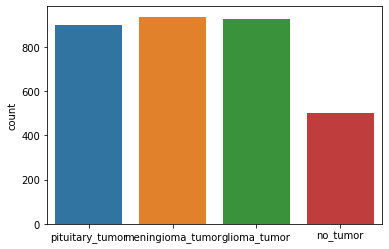

In [19]:
sns.countplot(y_train)
plt.show()

Sample of images in each class

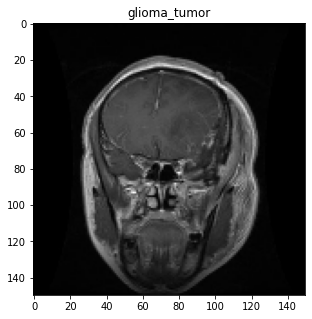

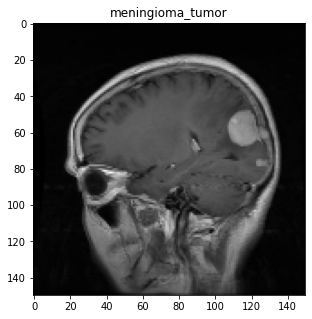

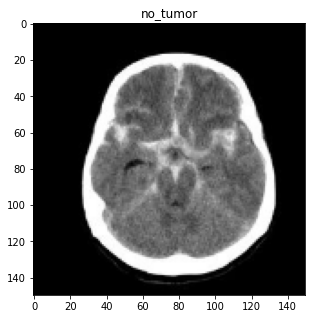

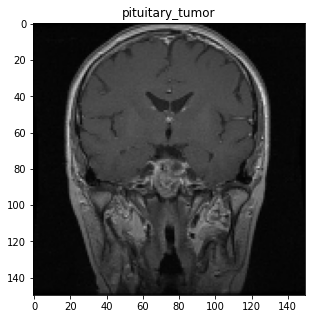

In [20]:
j=0
for i in class_names:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [21]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [22]:
# Split them into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2937, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2937,)  Test : (327,)


Encoding the y_train and y_test to numbers

In [23]:
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [24]:
# Using the Xception Model
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="imagenet", input_shape=inputShape, include_top=False)

In [25]:
# Adding the layers of Neural Network
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

Model summary

In [26]:
# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [27]:
# Creating callbacks
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

Training the model

In [28]:
# Compling and fitting the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
	epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard])

C:\Users\achyu\.conda\envs\tensor\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/12
244/244 [==============================] - 53s 201ms/step - loss: 0.7709 - accuracy: 0.7296 - val_loss: 0.9670 - val_accuracy: 0.7370

Epoch 00001: val_accuracy improved from -inf to 0.73700, saving model to xception.h5
Epoch 2/12
244/244 [==============================] - 46s 186ms/step - loss: 0.4925 - accuracy: 0.8362 - val_loss: 0.5005 - val_accuracy: 0.8196

Epoch 00002: val_accuracy improved from 0.73700 to 0.81957, saving model to xception.h5
Epoch 3/12
244/244 [==============================] - 49s 201ms/step - loss: 0.3748 - accuracy: 0.8636 - val_loss: 0.5571 - val_accuracy: 0.8257

Epoch 00003: val_accuracy improved from 0.81957 to 0.82569, saving model to xception.h5
Epoch 4/12
244/244 [==============================] - 79s 322ms/step - loss: 0.3478 - accuracy: 0.8855 - val_loss: 1.2067 - val_accuracy: 0.7798

Epoch 00004: val_accuracy did not improve from 0.82569
Epoch 5/12
244/244 [==============================] - 81s 330ms/step - loss: 0.2904 - accuracy: 0.90

Training, loss vs epoch.

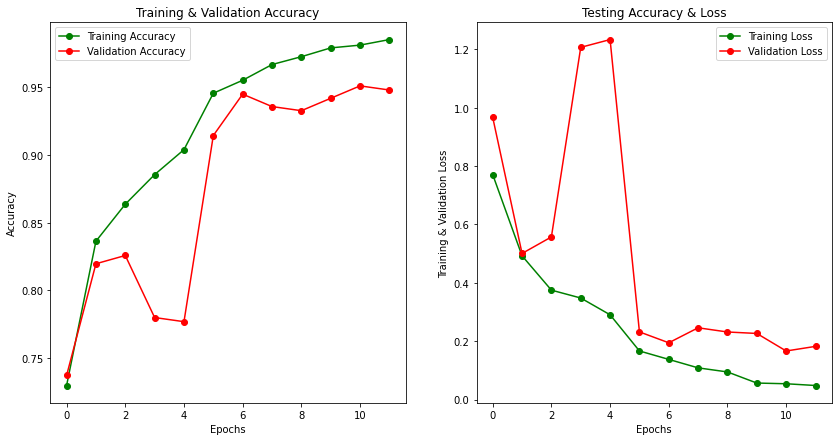

In [29]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

Model performance

In [30]:
# Evaluating Model
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

11/11 [==============================] - 2s 135ms/step - loss: 0.1821 - accuracy: 0.9480
Testing Loss : 0.18208648264408112
Testing Accuracy : 94.80122327804565 %


In [31]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

Classification Report

In [32]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        89
           1       0.96      0.87      0.91        92
           2       0.96      0.98      0.97        51
           3       0.90      1.00      0.95        95

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



Confusion Matrix

<AxesSubplot:>

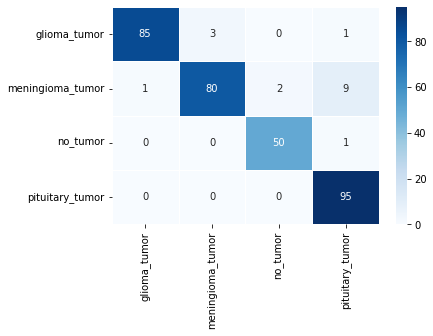

In [33]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)